In [10]:
from ProjectTools import OpenBeds
import math

dry = True

def filterDepth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount
    return df

if dry == True:
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

else:
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_3mod_mc, nano_3mod_hmc = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    
    nano_2mod = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

In [26]:
import pandas as pd

def filterMods(df):
    return df.loc[df["percentMeth"] == 100]

def filterHemiMods(df): 
    return df.loc[(df["percentMeth"] < 100) & (df["percentMeth"] > 0)]

def filterNoMods(df): 
    return df.loc[df["percentMeth"] == 0]

def nonZeroMod(df):
    return df.loc[df["percentMeth"] > 0]

def filterIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterHemiMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def noModsAtAll(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore"
    df1, df2 = map(filterNoMods, [df1, df2])
    return pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modUnmodIntersect(present, absent):
    present["method"], absent["method"] = "Nanopore", "Nanopore"
    intersect = filterHemiMods(present)
    exclusion = filterNoMods(absent)
    return  pd.merge(intersect, exclusion, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])

def modIntersect(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) == 100]

def totalOverlap(df1, df2):
    df1["method"], df2["method"] = "Nanopore", "Nanopore" 
    hemi_df1, hemi_df2 = filterHemiMods(df1), filterHemiMods(df2), 
    intersect = pd.merge(hemi_df1, hemi_df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    return intersect.loc[intersect[["percentMeth_x", "percentMeth_y"]].sum(axis=1) != 100]

In [40]:
def calculateModRatio(df1, df2):
    merged_df = pd.merge(df1, df2, "inner", on=["chromosome", "chromStart", "chromEnd", "strand", "readCount"])
    mod1, mod2 = df1["modification_type"][0], df2["modification_type"][0]
    merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = merged_df["percentMeth_x"].div(merged_df["percentMeth_y"], axis=0)
    merged_df.loc[merged_df["{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] == math.inf, "{mod1}_to_{mod2}_ratio".format(mod1=mod1, mod2=mod2)] = 1.0

    return merged_df[["chromosome", "chromStart", "chromEnd", "readCount", "5hmC_to_5mC_ratio", "strand"]]


In [50]:
from pybedtools import BedTool

def intersect_genes(ratio_df, gene_path):
    gene_ref_bed = BedTool(gene_path)
    ratio_bed = BedTool.from_dataframe(ratio_df)

    intersect = ratio_bed.intersect(gene_ref_bed, wb=True, s=True)
    names = ["chromosome", "chromStart", "chromEnd", "readCount", "strand", "thickStart", "thickEnd", "itemRgb", "gene_name", "blockSizes"]
    # redundant_cols = ["thickStart", "thickEnd", "itemRgb"]
    return intersect.to_dataframe(names=names)# .drop(columns=redundant_cols)



In [51]:
intersect_genes(calculateModRatio(nano_3mod_hmc, nano_3mod_mc), './feature_references/fig5_features/mm39_RefSeqC_select_merged.bed')

""


In [ ]:
from pybedtools import BedTool

gene_ref_bed = BedTool('./feature_references/fig5_features/mm39_RefSeqC_select_merged.bed')

ratio_bed = BedTool.from_dataframe(calculateModRatio(nano_3mod_hmc, nano_3mod_mc))


<Axes: >

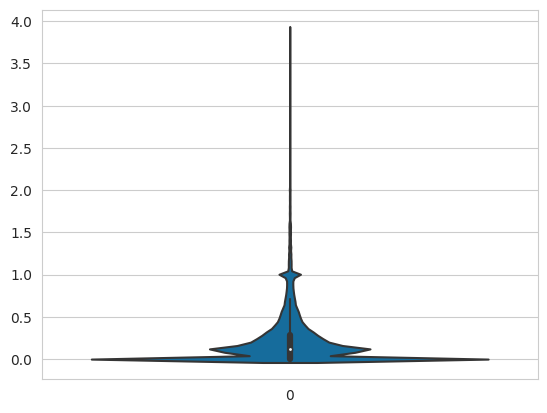

In [242]:
sns.violinplot(np.log2(ratio["5hmC_to_5mC_ratio"] + 1))

In [ ]:
fig.add_subplot(gs[0,0])
plv.venn2(subsets=(len(filterNoMods(nano_2mod)), 
                   len(filterMods(nano_2mod)), 
                   len(filterHemiMods(nano_2mod))),
                   set_labels=["C", "5mC"],
                   ax=ax1)

In [130]:
import upsetplot
from upsetplot import from_memberships

upsetplot_ds = from_memberships(
    [["C"], 
    ["5mC"],
    ["C", "5mC"],
    ["5hmC"],
    ["5mC", "5hmC"],
    ["C", "5hmC"],
    ["C", "5mC", "5hmC"],
    ],
    data = [
        len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_mc)), 
        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(filterMods(nano_3mod_hmc)), 
        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)), 
        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))
    ]
)
upset = upsetplot.UpSet(upsetplot_ds, show_percentages=True, show_counts="{:.2e}", facecolor="tab:grey", element_size=None, sort_categories_by="-input")


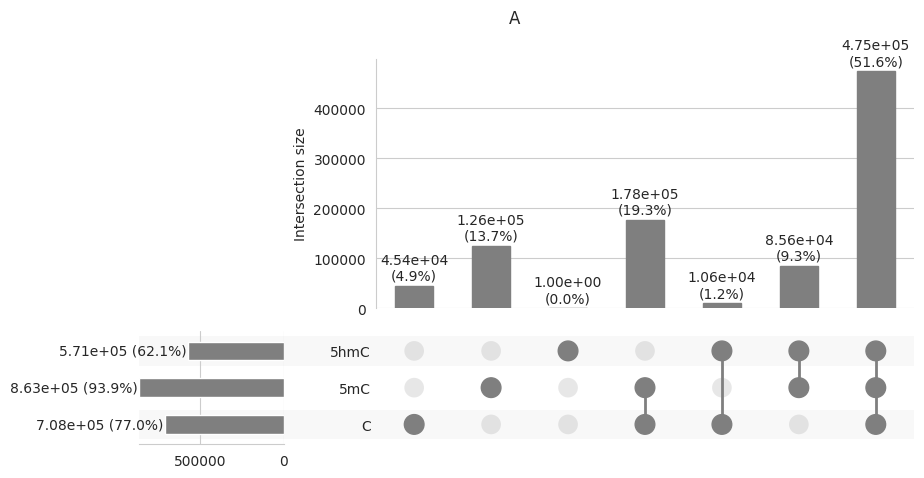

In [143]:
import matplotlib_venn as plv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, fig)

fig1 = fig.add_subfigure(gs[0, :])
fig1.suptitle("A")
upset.plot(fig1)

fig.show()

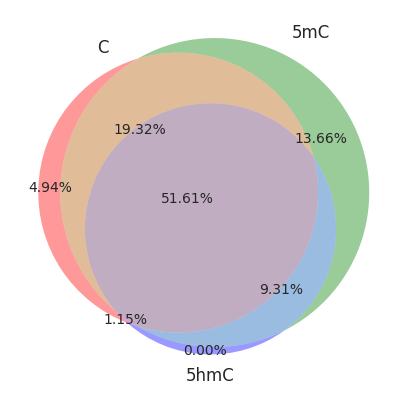

In [111]:
import matplotlib_venn as plv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0,:])
venn = plv.venn3(subsets=(len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc)), 
                        len(filterMods(nano_3mod_mc)),
                        len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc)),
                        len(filterMods(nano_3mod_hmc)),
                        len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc)),
                        len(modIntersect(nano_3mod_mc, nano_3mod_hmc)), 
                        len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))),
                        set_labels=["C", "5mC", "5hmC"],
                        ax=ax1)

total = len(pd.merge(nano_3mod_hmc, nano_3mod_mc, "inner", ["chromosome", "chromStart", "chromEnd", "method", "readCount"]))
venn.get_label_by_id("100").set_text("{:.2%}".format(len(noModsAtAll(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("010").set_text("{:.2%}".format(len(filterMods(nano_3mod_mc))/total))
venn.get_label_by_id("001").set_text("{:.2%}".format(len(filterMods(nano_3mod_hmc))/total))
venn.get_label_by_id("110").set_text("{:.2%}".format(len(modUnmodIntersect(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("101").set_text("{:.2%}".format(len(modUnmodIntersect(nano_3mod_hmc, nano_3mod_mc))/total))
venn.get_label_by_id("011").set_text("{:.2%}".format(len(modIntersect(nano_3mod_mc, nano_3mod_hmc))/total))
venn.get_label_by_id("111").set_text("{:.2%}".format(len(totalOverlap(nano_3mod_mc, nano_3mod_hmc))/total))

